### MEC2015 - System Identification

#### Student: Felipe da Costa Pereira



#### Exercise 1 - ARMAX (Activity 06)
Build ARMAX models for the robot arm data used previoously, with either options below (pick only one, whichever suits you best):
- R: from [4] given in the user manual (see example 2) on this link 
- Python 1: see statsmodels.tsa.arima.model.ARIMA (ARMA models with exogenous variables)
- Python 2: see sysidentpy package (ARMAX models) in the website link

Present your results in terms of FR simulation and correlation tests. Compare with the best results from ARX models obtained previoulsy.

#### Exercise 2 - NARMAX (Current Activity 08)
Build NARMAX models for the robot arm data, with either options below (pick only one, whichever suits you best):  
- R: from [4] given in the user manual (see example 1, 3, or 4) on this link
- Python: sysidentpy package
Present your results in terms of FR simulation and correlation tests. Compare (N)ARMAX models for this dataset.

#### Importing packages

In [273]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sysidentpy.general_estimators import NARX
from sysidentpy.model_structure_selection import FROLS

from sysidentpy.basis_function._basis_function import Polynomial
from sysidentpy.metrics import root_relative_squared_error, mean_squared_error
from sysidentpy.utils.generate_data import get_siso_data
from sysidentpy.utils.display_results import results
from sysidentpy.utils.plotting import plot_residues_correlation, plot_results
from sysidentpy.residues.residues_correlation import compute_residues_autocorrelation, compute_cross_correlation

from sklearn.linear_model import LinearRegression, BayesianRidge, ARDRegression
from sklearn.metrics import r2_score

#### Reading data

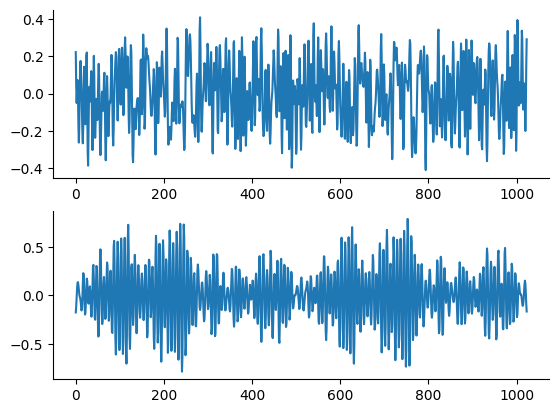

In [2]:
data = np.loadtxt('robot_arm.dat')

U=data[:,0]
Y=data[:,1]

f,ax = plt.subplots(2)
ax[0].plot(U)
ax[1].plot(Y)

#### Preparing data

Splittng data the same way as previsously (50% for parameters estimation, 50% validation)

In [3]:
utra = U[:512]
uval = U[512:]
ytra = Y[:512]
yval = Y[512:]

In order to apply the fit method, the datasets need to be reshaped

In [265]:
utra = np.reshape(utra, (-1,1))
ytra = np.reshape(ytra, (-1,1))
uval = np.reshape(uval, (-1,1))
yval = np.reshape(yval, (-1,1))
u = np.reshape(U, (-1,1))
y = np.reshape(Y, (-1,1))

Models Orders to be tested 

In [266]:
orders = [2,3,4,6,10,15]

#### ARMAX - Main loop for a range of orders (Free run simulation using the whole data)

In [268]:
# LINEAR (n=1)
basis_function_linear = Polynomial(degree=1)

# storing results
dict_ar = {
    'orders': [], 'yhat_OSA': [], 'yhat_FR': [], 'ee': [], 'r2': [], 'ue': [],
}

for order in orders:
    m_armax = NARX(
        xlag=int(order),
        ylag=int(order),
        model_type='NARMAX',
        basis_function=basis_function_linear,
        base_estimator=LinearRegression(),
    )
    m_armax.fit(X=utra, y=ytra)

    yhat_OSA_ar = m_armax.predict(X=utra, y=ytra, steps_ahead=1)    
    # yhat_FR_ar = m_armax.predict(X=uval, y=yval)
    yhat_FR_ar = m_armax.predict(X=u, y=y)

    ee_ar = compute_residues_autocorrelation(ytra, yhat_OSA_ar)
    ue_ar = compute_cross_correlation(ytra, yhat_OSA_ar, uval)
    
    # r2_ar = r2_score(yval, yhat_FR_ar)
    r2_ar = r2_score(y, yhat_FR_ar)
    
    dict_ar['orders'].append(order)
    dict_ar['yhat_OSA'].append(yhat_OSA_ar)
    dict_ar['yhat_FR'].append(yhat_FR_ar)
    dict_ar['ee'].append(ee_ar[0])
    dict_ar['ue'].append(ue_ar[0])
    dict_ar['r2'].append(r2_ar)

#### NARMAX - Main loop for a range of orders (Free run simulation using the whole data)


In [454]:
# storing results
dict_nar2 = {
    'orders': [], 'yhat_OSA': [], 'yhat_FR': [], 'ee': [], 'r2': [], 'ue': [],
}

# testing several non linear degrees, best is 3.
print('nl', 'order', 'R2', 'n_terms')
for nl in [3]:
    for order in orders:
        m_narmax = FROLS(
            order_selection=True,
            n_info_values=15,
            # n_terms=15,
            extended_least_squares=True,
            ylag=int(order), xlag=int(order),elag=int(order),
            estimator='least_squares',
            basis_function=Polynomial(degree=nl),
        )

        m_narmax.fit(X=utra, y=ytra)
        
        yhat_OSA_nar = m_narmax.predict(X=utra, y=ytra, steps_ahead=1)
        
        # yhat_FR_nar = m_narmax.predict(X=uval, y=yval)
        yhat_FR_nar = m_narmax.predict(X=u, y=y)

        ee_nar = compute_residues_autocorrelation(ytra, yhat_OSA_nar)
        ue_nar = compute_cross_correlation(ytra, yhat_OSA_nar, uval)
        # r2_nar = r2_score(yval, yhat_FR_nar)
        r2_nar = r2_score(y, yhat_FR_nar)
        
        print(nl, order, r2_nar, m_narmax.n_terms);

        dict_nar2['orders'].append(order)
        dict_nar2['yhat_OSA'].append(yhat_OSA_nar)
        dict_nar2['yhat_FR'].append(yhat_FR_nar)
        dict_nar2['ee'].append(ee_nar[0])
        dict_nar2['ue'].append(ue_nar[0])
        dict_nar2['r2'].append(r2_nar)


nl order R2 n_terms
3 2 0.2574018634048332 8
3 3 0.6228390702355001 15
3 4 0.5248070483524577 15
3 6 0.9975880373520813 15
3 10 0.6410629679409887 15


c:\Users\bewm\AppData\Roaming\Python\env\env_sys\lib\site-packages\sysidentpy\parameter_estimation\estimators.py:114: UserWarning: Psi matrix might have linearly dependent rows.Be careful and check your data
  self._check_linear_dependence_rows(psi)


3 15 0.9986313362339836 15


#### Comparing ARMAX and NARMAX - Plot Results

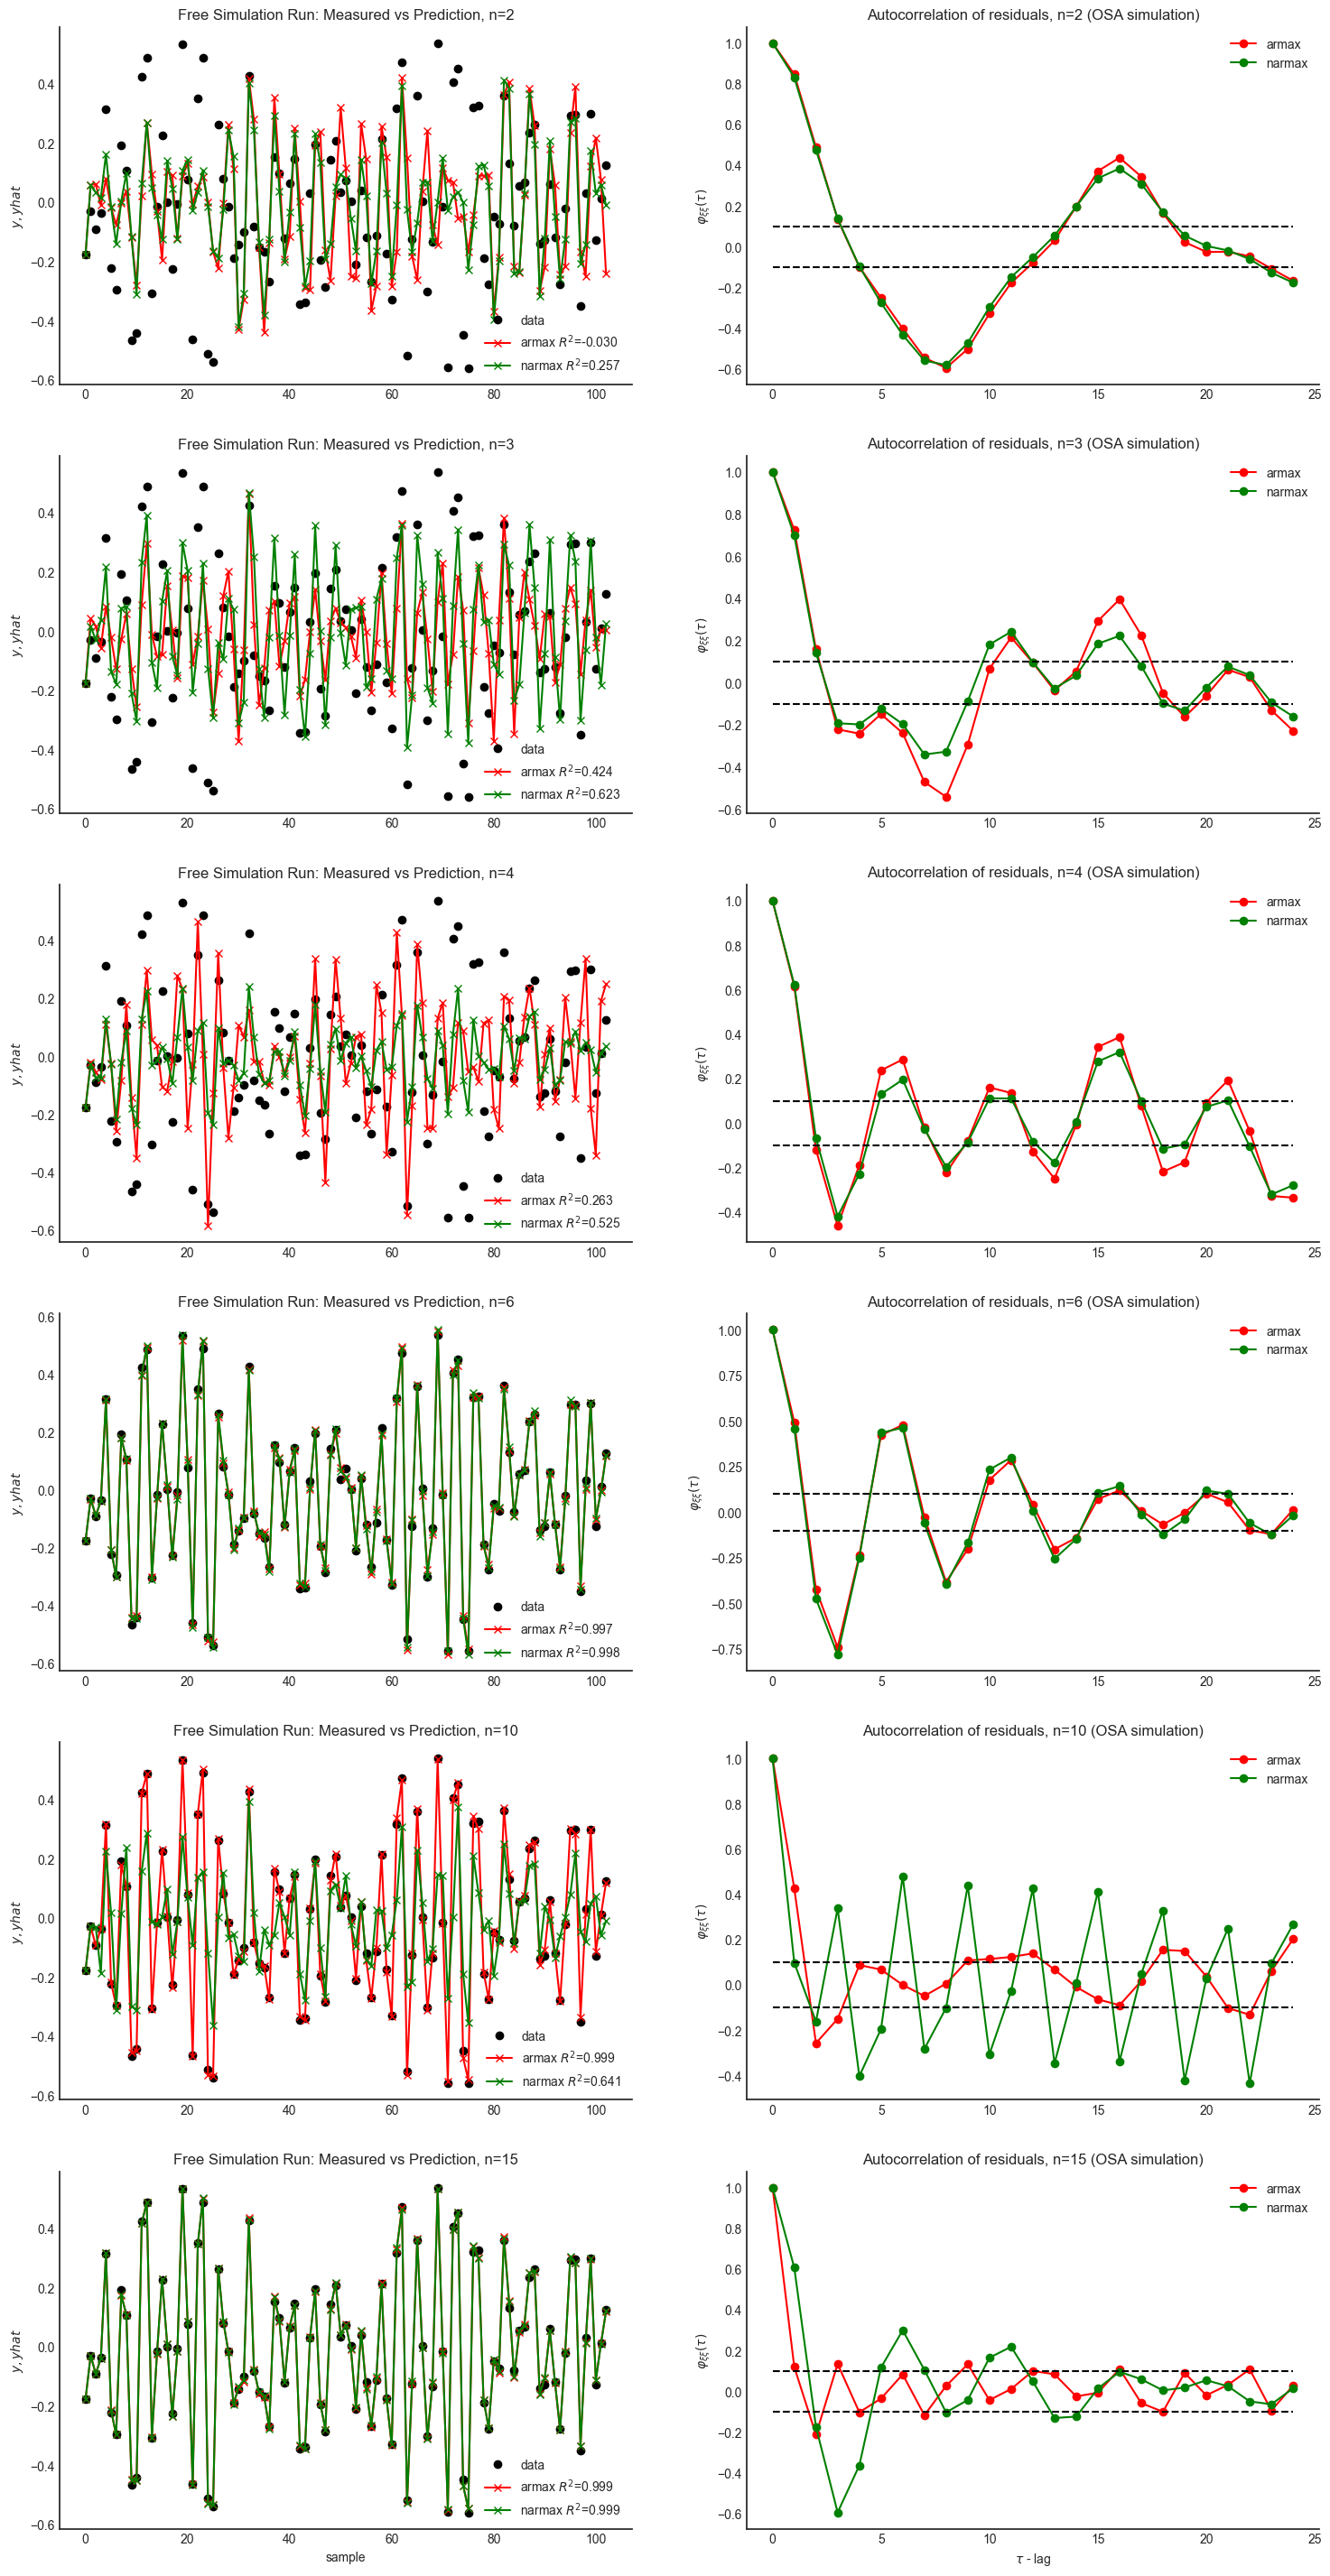

In [478]:
sample_rate = 10
autocorr_lags = 25

no = len(orders)

plt.subplots(no,2,figsize=(18,6*no))
for i,o in enumerate(orders):

    plt.subplot(no,2,2*i+1)
    r2_ar=dict_ar['r2'][i]
    r2_nar=dict_nar2['r2'][i]
    plt.title(f'Free Simulation Run: Measured vs Prediction, n={o}')
    # plt.plot(yval[::sample_rate], 'o', c='k')
    plt.plot(y[::sample_rate], 'o', c='k')
    plt.plot(dict_ar['yhat_FR'][i][::sample_rate], 'x-', c='r')
    plt.plot(dict_nar2['yhat_FR'][i][::sample_rate], 'x-', c='g')
    plt.legend(['data',f'armax $R^2$={r2_ar:.3f}', f'narmax $R^2$={r2_nar:.3f}'])
    plt.ylabel('$y,yhat$')
    if i==no-1:        plt.xlabel('sample')

    plt.subplot(no,2,2*i+2)
    plt.title(f'Autocorrelation of residuals, n={o} (OSA simulation)')
    plt.plot(dict_ar['ee'][i][:autocorr_lags], 'o-', c='r')
    plt.plot(dict_nar2['ee'][i][:autocorr_lags], 'o-', c='g')
    plt.plot([0.1 for i in range(autocorr_lags)], 'k--')
    plt.plot([-0.1 for i in range(autocorr_lags)], 'k--')
    plt.legend(['armax', 'narmax'])
    plt.ylabel(r'$\varphi_{\xi\xi}(\tau)$')
    if i==no-1:        plt.xlabel(r'$\tau$ - lag')

Comments on the results:

- Several non-linearity degrees were tested for the Narmax Polynomial basis function, best result was obtained with $n_{l} = 3$
- For lower model orders like $n_{a}, n_{b} = 2, 3, 4$ the NARMAX model improves the model, but for higher orders it seems like ARMAX behaves better. 
- In the NARMAX model the set of parameters to be fitted is much higher

#### Information criteria to choose model order.

The Akaike information criterion (AIC) is a mathematical method for evaluating how well a model fits the data it was generated from. In statistics, AIC is used to compare different possible models and determine which one is the best fit for the data. AIC is calculated from:

    - the number of independent variables used to build the model.
    - the maximum likelihood estimate of the model (how well the model reproduces the data).

The best-fit model according to AIC is the one that explains the greatest amount of variation using the fewest possible independent variables.

(https://www.scribbr.com/statistics/akaike-information-criterion/)


The aic criterion has resulted a model with 15 terms. Several tests were made selecting different number of terms in the final NARMAX model, but the same number of terms was found.

In [480]:
m_narmax.n_terms

15

Information criteria values (the best model comparing different number of terms is the one with the lowest aic value (n_terms=15))

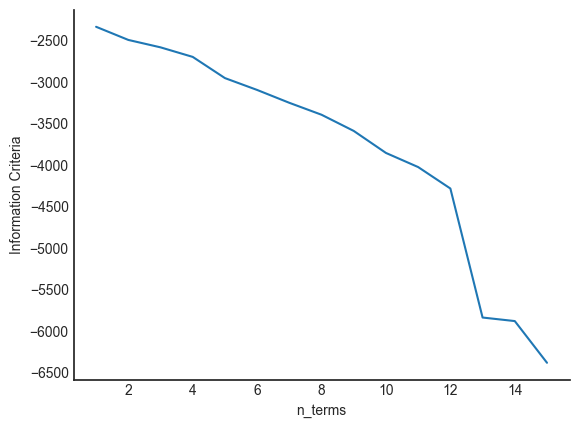

In [479]:
xaxis = np.arange(1, m_narmax.n_info_values + 1)
plt.plot(xaxis, m_narmax.info_values)
plt.xlabel('n_terms')
plt.ylabel('Information Criteria')
pass;

#### Model Terms (x means u)

In [481]:
r = pd.DataFrame(
    results(
        m_narmax.final_model, m_narmax.theta, m_narmax.err,
        m_narmax.n_terms, err_precision=5),
    columns=['term', 'theta', 'error']        
)
print (r)

                  term    theta    error
0               y(k-4)  -0.6962  0.88536
1              x1(k-2)   0.6106  0.03160
2              x1(k-7)   0.0290  0.01395
3              y(k-12)  -0.1614  0.01448
4               y(k-8)  -0.2186  0.02204
5   x1(k-11)x1(k-10)^2   0.0011  0.00824
6              x1(k-3)  -0.3947  0.00656
7             x1(k-10)  -0.1611  0.00453
8              y(k-14)  -0.1859  0.00433
9             x1(k-13)  -0.0837  0.00371
10             y(k-15)   0.0110  0.00152
11             x1(k-1)  -0.5557  0.00150
12             y(k-10)  -0.5227  0.00209
13              y(k-1)   0.4455  0.00001
14             x1(k-5)   0.3000  0.00006


Comments:  
- We can see that most part of the model terms are of order 1, what could explain why the NARMAX model doesn't show much improvements when comparing to the ARMAX ones.

#### Using sysidentpy built in functions to plot data.

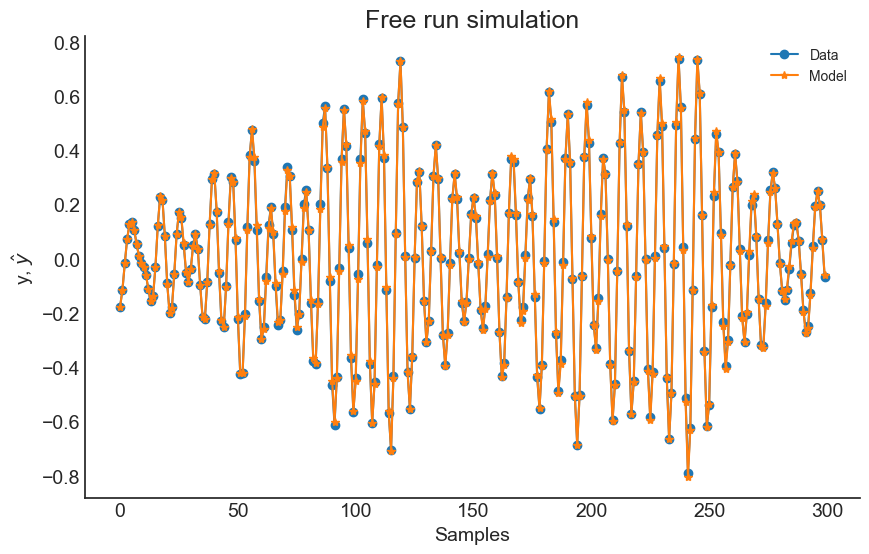

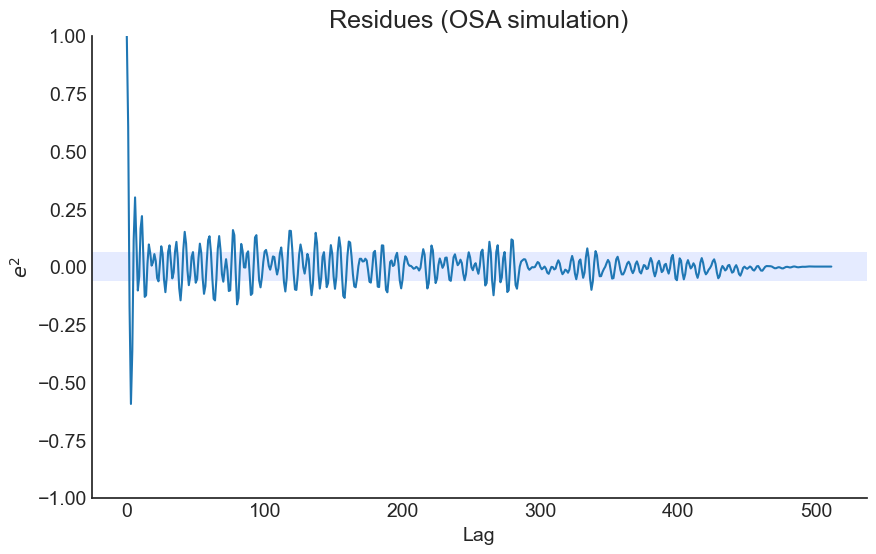

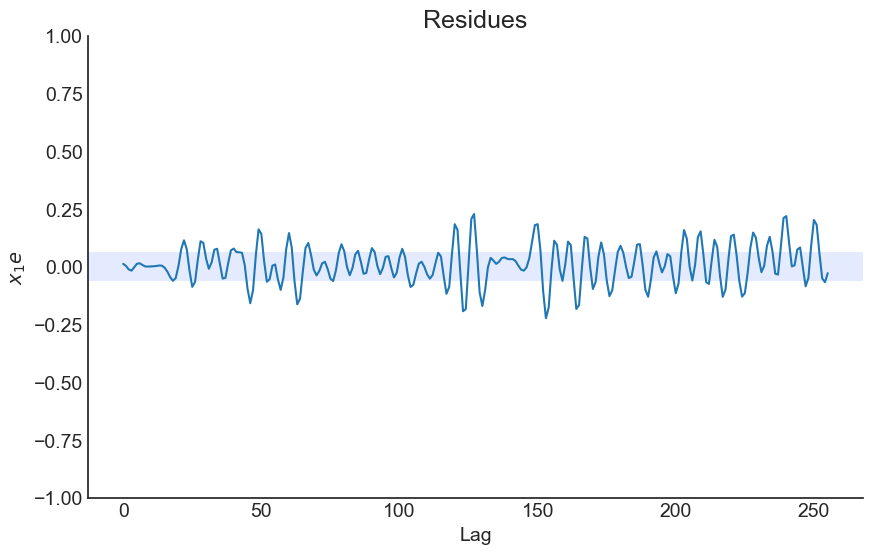

In [468]:
plot_results(y=y, yhat=yhat_FR_nar, n=300)
ee = compute_residues_autocorrelation(ytra, yhat_OSA_nar)
plot_residues_correlation(data=ee, title="Residues (OSA simulation)", ylabel="$e^2$")
ue = compute_cross_correlation(ytra, yhat_OSA_nar, utra)
plot_residues_correlation(data=ue, title="Residues (OSA simulation)", ylabel="$ue$")
